In [ ]:
!pip install langchain pandas pikepdf pypdf tiktoken huggingface-hub python-dotenv openai faiss-cpu unstructured pdf2image pdfminer.six opencv-python pytesseract unstructured.pytesseract unstructured_inference sentence_transformers chromadb langchainhub llama_cpp_python accelerate bitsandbytes gpt4all

In [ ]:
import os
from typing import Union, List, Dict
import abc
import datetime

import json
import pandas as pd
from dotenv import load_dotenv
from tqdm.auto import tqdm
from transformers import GPT2Model, GPT2LMHeadModel, GPT2Tokenizer, GPT2Config, DistilBertForMaskedLM, DistilBertTokenizer

from langchain import HuggingFaceHub
from langchain import hub
from langchain.chains import LLMChain, RetrievalQA
from langchain.document_loaders import DataFrameLoader
from langchain.embeddings import CacheBackedEmbeddings, OpenAIEmbeddings, HuggingFaceEmbeddings
from langchain.vectorstores import FAISS, Chroma
from langchain.llms import OpenAI, VLLM, LlamaCpp, GPT4All
from langchain.llms.base import LLM
from langchain.prompts import PromptTemplate
from langchain.schema import StrOutputParser
from langchain.schema.embeddings import Embeddings
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.vectorstore import VectorStore
from langchain.storage import LocalFileStore
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter
from langchain.document_loaders import UnstructuredPDFLoader
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.chains.question_answering import load_qa_chain
from langchain.schema.document import Document
from langchain.text_splitter import TextSplitter
from PIL import Image as PILImage


# Pipeline
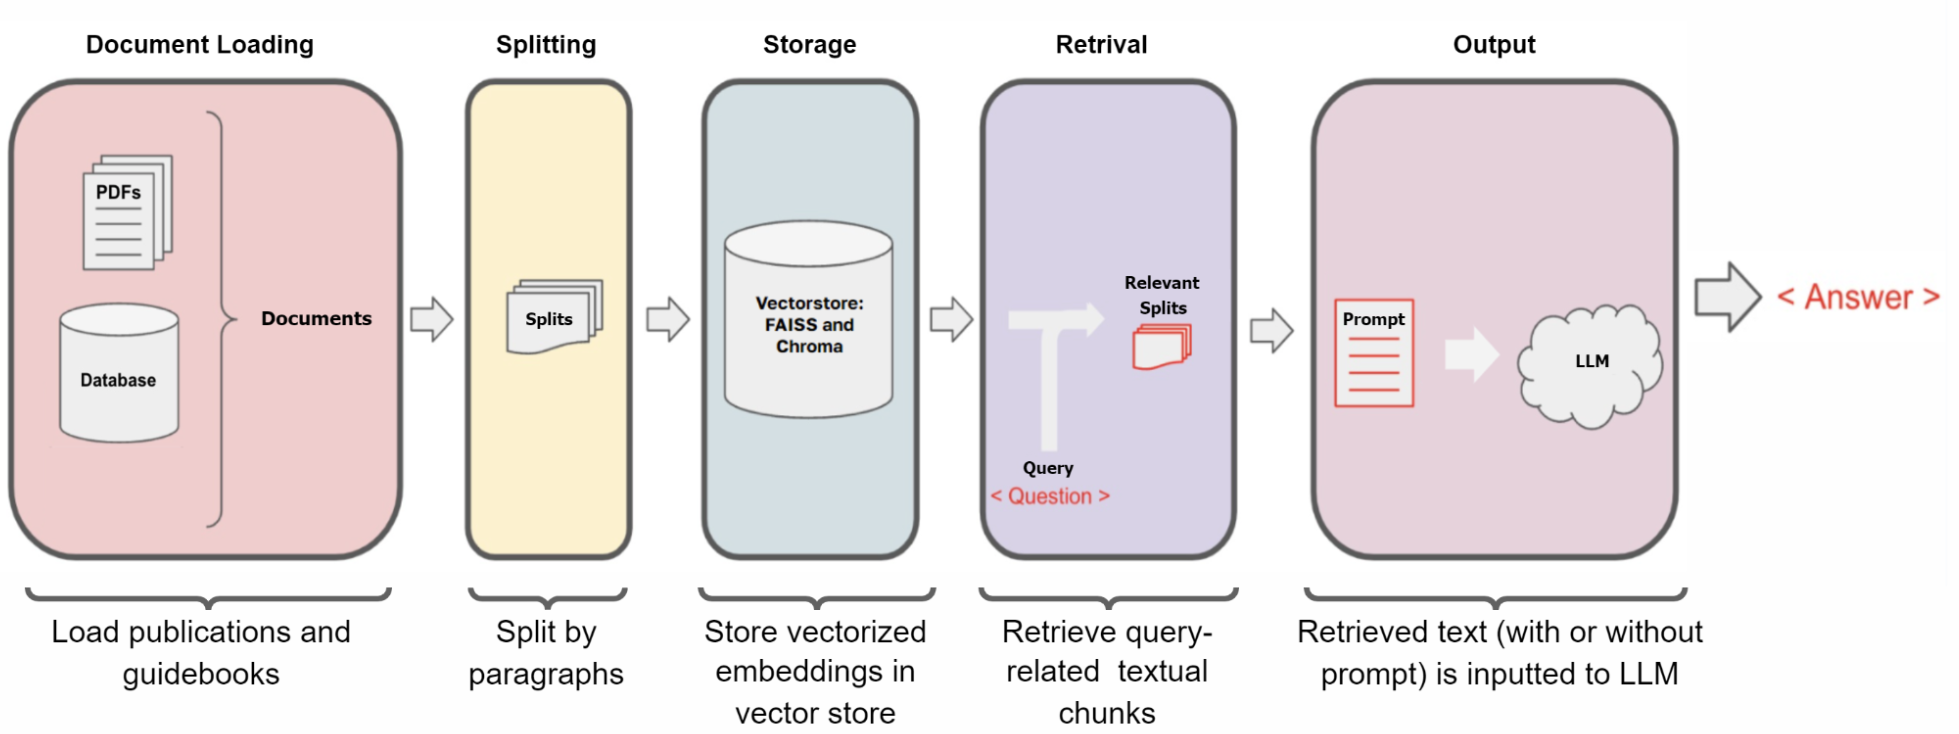

# Код решения

In [ ]:
class TextSplitterFactory:
    """Фабрика предпоготовленных сплитторов, которые можно испозовать в экспериментах"""

    def __init__(self, chunk_size: int = 400, chunk_overlap: int = 20):
        """
        Parameters
        ----------
        chunk_size:
            Максимальный размер возвращаемого чанка (документа)
            Большие значения увеличивают длину промпта llm и могут достигнуть ограничения или дольше обработываться
            Маленькие значения могут привести к потере смысла документа
            В листе A4 около 2000 символов
            Значение по умолчанию 400
        chunk_overlap:
            Перекрытие чанков между собой
        """
        self.chunk_size = chunk_size
        self.chunk_overlap = chunk_overlap


    def сharacter_splitter(self) -> TextSplitter:
        """Возращает CharacterTextSplitter с параметрами по умолчанию"""

        return CharacterTextSplitter(
                    separator = "\n\n",
                    chunk_size = self.chunk_size,
                    chunk_overlap  = self.chunk_overlap,
                    length_function = len,
                    is_separator_regex = False,
                )


    def recursive_splitter(self) -> TextSplitter:
        """Возращает RecursiveCharacterTextSplitter с параметрами по умолчанию"""

        return RecursiveCharacterTextSplitter(
                chunk_size = self.chunk_size,
                chunk_overlap  = self.chunk_overlap,
                length_function = len,
                is_separator_regex = False,
            )


In [ ]:
class EmbedderFactory:
    """Фабрика предпоготовленных эмбеддиров, которые можно испозовать в экспериментах """

    def create_embeddings(
            self,
            underlying_embeddings: Embeddings,
            cache_path_name: str = '',
            base_cache_path = '../cache/') -> CacheBackedEmbeddings:
        """
        Формурует эмбеддинги с использованием кеша
        Фактически является оберткой над Embeddings, позволяющей кешировать результат на диск

        underlying_embeddings : Embeddings
            Объект Embeddings, который отвечает за формировние
        cache_path_name: str
            Имя подпапки для сохранения кеша
        base_cache_path:
            Путь к базовой папке храннеия кешей

        Returns
        -------
        CacheBackedEmbeddings
            Объект для потроения кешей для перадачи дальше по цепочке в индексацию
        """

        # создаем при необходимости общую папку с кешом
        if not os.path.exists(base_cache_path):
            os.mkdir(base_cache_path)

        # задаем хранилище
        fs = LocalFileStore(os.path.join(base_cache_path, cache_path_name))

        # определяем название модели (будет в начале имени созданных файлов)
        if hasattr(underlying_embeddings, 'model'):
            namespace = underlying_embeddings.model
        elif hasattr(underlying_embeddings, 'model_name'):
            namespace = underlying_embeddings.model_name
        else:
            namespace = cache_path_name

        # обертка для кеширования
        return CacheBackedEmbeddings.from_bytes_store(
            underlying_embeddings, fs, namespace=namespace
        )


    def calculate_embeddings_to_cache(self,
        embedder: Embeddings,
        documents: List[Document],
        emb_chunk_size: int = 10):

        """
        Обрабатывает документы, сохраняет в кеш

        Parameters
        ----------
        embedder: CacheBackedEmbeddings
            Эмбеддер с коддержкой кеширования
        documents: List[Document]
            Список документов. Документы будут обработаны и разультат сохранен в кеше для повторного исопльзования
        emb_chunk_size: int
            Количество обрабатываемых документов за один вызов.
            Полезно при использовании OpenAI API, так есть ограничение, по умолчанию 10
        """

        for start_index in tqdm(range(len(documents) // emb_chunk_size + 1)):
            embedder.embed_documents(
                [x.page_content for x in documents[start_index * emb_chunk_size : (start_index + 1) * emb_chunk_size]])


    def OpenAI_embedder(self,
        openai_api_key: Union[str, None] = None) -> CacheBackedEmbeddings:

        """Возвращает OpenAIEmbeddings с поддержкой кеширования
        https://python.langchain.com/docs/integrations/text_embedding/openai

        Parameters
        ----------
        openai_api_key: Union[str, None]
            OPENAI_API_KEY нужен для работы с API OpenAI.
            Ключ может быть передан в качестве параметра, или взят из переменной окружения OPENAI_API_KEY.
        """

        if openai_api_key is None and os.environ.get("OPENAI_API_KEY", None) is not None:
            openai_api_key = os.environ.get("OPENAI_API_KEY", None)

        if openai_api_key is None:
            raise ValueError('Параметр должен быть задан, либо OPENAI_API_KEY должен быть в переменных окружения')

        return self.create_embeddings(
            underlying_embeddings = OpenAIEmbeddings(openai_api_key=openai_api_key),
            cache_path_name = "OpenAI"
        )


    def E5_embedder(self) -> CacheBackedEmbeddings:
        """Возвращает HuggingFaceEmbeddings intfloat/e5-large-v2 с поддержкой кеширования
        https://python.langchain.com/docs/integrations/text_embedding/huggingfacehub
        """

        return self.create_embeddings(
            underlying_embeddings = HuggingFaceEmbeddings(model_name="intfloat/e5-large-v2"),
            cache_path_name = "E5"
        )

    def Roberta_embedder(self, documents: List[Document] = []) -> CacheBackedEmbeddings:
        """Возвращает HuggingFaceEmbeddings intfloat/e5-large-v2 с поддержкой кеширования
        https://python.langchain.com/docs/integrations/text_embedding/huggingfacehub
        """

        return self.create_embeddings(
            underlying_embeddings = HuggingFaceEmbeddings(model_name="roberta-base"),
            cache_path_name = "roberta-base"
        )

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class LlmFactory():
    """Фабрика предпоготовленных моделей LLM, которые можно испозовать в экспериментах"""

    # Для тестов разных моделей менялся model_path,
    # т.к. в любом случае в пределах одной сессии не удавалось для 2х моделей провести эксперименты,
    # из-за того, что тратится очень много времени на генерацию ответов и google colab прекращает сеанс.
    # Значения могут быть:
    # "/content/drive/MyDrive/llama-2-7b.Q4_0.gguf"
    # и
    # "/content/drive/MyDrive/llama-2-7b.Q4_K_M.gguf"
    #
    def Llama2(self, model_path="/content/drive/MyDrive/llama-2-7b.Q4_0.gguf"):
        """https://python.langchain.com/docs/integrations/llms/llamacpp

        Можно подбирать оптимальные гиперпараметры модели

        Ссылки, где можно скачать модели
        https://huggingface.co/TheBloke/OpenOrca-Platypus2-13B-GGUF/tree/main
        https://huggingface.co/TheBloke/Llama-2-7B-GGUF/tree/main
        https://huggingface.co/TheBloke/Llama-2-13B-GGUF/tree/main
        """

        callback_manager = CallbackManager([StreamingStdOutCallbackHandler()])

        return LlamaCpp(
            model_path=model_path,
            temperature=0.75,
            max_tokens=400,
            n_gpu_layers=8,  # comment if cpu
            n_batch=32,      # comment if cpu
            top_p=1,
            callback_manager=callback_manager,
            verbose=True,  # Verbose is required to pass to the callback manager
        )


    def gpt4all(self):
        """
        Модель Gpt4all 7b

        Ссылка для скачивания модели
        https://gpt4all.io/models/gguf/gpt4all-falcon-q4_0.gguf

        """

        callbacks = [StreamingStdOutCallbackHandler()]
        return GPT4All(model='../models/gpt4all-falcon-q4_0.gguf', backend="gptj", callbacks=callbacks, verbose=True)


    def OpenAI(self,
        openai_api_key: Union[str, None] = None) -> CacheBackedEmbeddings:

        """Модель OpenAI

        Parameters
        ----------
        openai_api_key: Union[str, None]
            OPENAI_API_KEY нужен для работы с API OpenAI.
            Ключ может быть передан в качестве параметра, или взят из переменной окружения OPENAI_API_KEY.
        """

        if openai_api_key is None and os.environ.get("OPENAI_API_KEY", None) is not None:
            openai_api_key = os.environ.get("OPENAI_API_KEY", None)

        if openai_api_key is None:
            raise ValueError('Параметр должен быть задан, либо OPENAI_API_KEY должен быть в переменных окружения')

        return OpenAI(temperature=0, openai_api_key=OPENAI_API_KEY, max_tokens=500)


    def Mistral(self):
        """https://python.langchain.com/docs/integrations/llms/vllm"""

        raise NotImplementedError()

        # return VLLM(
        #     model="mosaicml/mpt-7b", # "mistralai/Mistral-7B-v0.1"
        #     trust_remote_code=True,  # mandatory for hf models
        #     max_new_tokens=128,
        #     top_k=10,
        #     top_p=0.95,
        #     temperature=0.8,
        # )

In [ ]:
class RAGSolution:
    """Класс для решения задачи RAG"""

    def __init__(self,
        text_splitter: Union[str, TextSplitter] = 'recursive',
        embedder: Union[str, Embeddings] = 'E5',
        vector_store: Union[str, VectorStore] = 'FAISS',
        # параметры для поиска топ 2 частей документов
        retriever_wargs: Dict = {"search_type":"similarity", "search_kwargs":{"k": 2}},
        prompt_template: Union[str, None] = None,
        llm: Union[str, LLM] = 'LLaMa-2'):
        """
        Инициализация класса

        Parameters
        ----------
        text_splitter : Union[str, TextSplitter]
            Либо строка, которая может принимать одно из значений ['recursive', 'character']
            Либо экземплят класса TextSplitter
            Рекомендуется значение 'recursive'
        embedder: Union[str, Embeddings] = 'E5'
            Эмбеддер.
            Либо строка, которая может принимать одно из значений ['openai', 'roberta', 'E5']
            Либо экземпляр класса Embeddings
            Значение по умолчанию 'E5'
        vector_store: str
            Векторное хранилище, в случае инициализации методом from_pdf_documents
            Возможные значения ['FAISS', 'Chroma']
            Если требуется использование собственного VectorStore, то следует использвоать инициализация через from_vector_store,
                это может быть полезно, например, при чтении сохраненного хранилища
        retriever_wargs: Dict
            Праметры, которые будут пераданы при создании ретривера
            По умолчанию {"search_type":"similarity", "search_kwargs":{"k": 2}}
        prompt_template: Union[str, None]
            Шаблон промпта. Если None, то будет заполнен значением по умолчанию
        llm: Union[str, LLM]
            Языковая модель.
            Либо строка, которая может принимать одно из значений ['LLaMa-2', 'gpt4all', 'Mistral', 'OpenAI']
            Либо экземпляр класса LLM
        """

        if not isinstance(text_splitter, TextSplitter) and text_splitter not in ['recursive', 'character']:
            raise ValueError("Параметр text_splitter может принимать значения ['recursive', 'character'] или быть объектом TextSplitter")

        if isinstance(embedder, Embeddings) and embedder not in ['openai', 'roberta', 'E5']:
            raise ValueError("Параметр embedder может принимать значения ['openai', 'roberta', 'E5'] или быть объектом Embeddings")

        if isinstance(vector_store, VectorStore) and vector_store not in ['FAISS', 'Chroma']:
            raise ValueError("Параметр vector_store может принимать значения ['FAISS', 'Chroma'] или быть объектом VectorStore")

        if isinstance(llm, LLM) and llm not in ['LLaMa-2', 'gpt4all', 'Mistral', 'OpenAI']:
            raise ValueError("Параметр llm может принимать значения ['LLaMa-2', 'gpt4all', 'Mistral', 'OpenAI'] или быть объектом LLM")

        # Если не предоставлен prompt template, используем дефолтный - просто просим модель ответить на вопрос, используя контекст
        if prompt_template is None:
            prompt_template = """Use the following pieces of context to answer the question at the end.
{context}
Question: {question}
Helpful Answer:"""

        # альтернативный вариант: self.prompt = hub.pull("rlm/rag-prompt")
        self.prompt = PromptTemplate.from_template(prompt_template)

        self.text_splitter_param = text_splitter
        self.embedder_param = embedder
        self.vector_store_param = vector_store
        self.retriever_wargs = retriever_wargs
        self.llm_param = llm

        self.retriever = None
        self.llm = None
        self.dllm = None


    def get_embedder(self):
        if isinstance(self.embedder_param, Embeddings):
            embedder = self.embedder_param
        elif self.embedder_param == 'openai':
            embedder = EmbedderFactory().OpenAI_embedder()
        elif self.embedder_param == 'roberta':
            embedder =  EmbedderFactory().Roberta_embedder()
        elif self.embedder_param == 'E5':
            embedder =  EmbedderFactory().E5_embedder()
        else:
            raise ValueError("Embedder педеданн некорректно конструктору класса")

        return embedder


    def split_documents(self, pdf_files: List[str]) -> List[Document]:
        """
        Собирает информацию из pdf документов и разбивает их на документы, которые будут индексироваться

        Parameters
        ----------
        pdf_files : List[str]
            Список имен файлов для обработки

        Returns
        -------
        List[Document]
            Список документов

        """

        if isinstance(self.text_splitter_param, TextSplitter):
            text_splitter = text_splitter
        elif self.text_splitter_param == 'recursive':
            text_splitter = TextSplitterFactory().recursive_splitter()
        elif self.text_splitter_param == 'character':
            text_splitter = TextSplitterFactory().сharacter_splitter()
        else:
            raise ValueError("TextSplitter педеданн некорректно конструктору класса")

        documents = []
        for fn in pdf_files:
            documents += UnstructuredPDFLoader(fn).load_and_split(text_splitter=text_splitter)

        return documents


    def format_docs(self, docs):
        return "\n\n".join(doc.page_content for doc in docs)


    def from_vector_store(self, vector_store: VectorStore):
        """Инициализация на основе объекта VectorStore"""
        self.retriever = vector_store.as_retriever(**self.retriever_wargs)


    def from_pdf_documents(self, pdf_files: List[str]):
        """Инициализация на основе списка файлов документов для обработки


        Parameters
        ----------
        pdf_files : List[str]
            Список имен файлов для обработки
        """

        # получаем список "частей" документов
        documents = self.split_documents(pdf_files)
        embedder = self.get_embedder()

        # сохраняем части документов в vector storage
        if self.vector_store_param == 'FAISS':
            # https://python.langchain.com/docs/integrations/vectorstores/faiss
            vector_store = FAISS.from_documents(documents, embedder)
        elif self.vector_store_param == 'Chroma':
            # https://python.langchain.com/docs/integrations/vectorstores/chroma
            vector_store = Chroma.from_documents(documents, embedder)
        else:
            raise ValueError("vector_store переданн некорректно конструктору класса")

        # используем vector storage как retriever
        self.retriever = vector_store.as_retriever(**self.retriever_wargs)


    def get_llm(self):
        if self.llm is not None:
            llm = self.llm
        elif isinstance(self.llm_param, LLM):
            llm = self.llm_param
        elif self.llm_param == 'LLaMa-2':
            llm = LlmFactory().Llama2()
        elif self.llm_param == 'Mistral':
            llm = LlmFactory().Mistral()
        elif self.llm_param == 'gpt4all':
            llm = LlmFactory().gpt4all()
        elif self.llm_param == 'OpenAI':
            llm = LlmFactory().OpenAI()
        else:
            raise ValueError("llm переданн некорректно конструктору класса")

        self.llm = llm

        return llm


    def answer(self, question: str) -> str:
        """Генерация ответа на вопрос"""

        if self.retriever is None:
            raise Exception('Инициализируйте вначале методами from_pdf_documents или from_vector_store')

        # получаем релевантные документы относительно нашего вопроса
        relevant_documents = self.retriever.get_relevant_documents(question)

        # передаем контекст и вопрос в prompt
        text_prompt = self.prompt.invoke(
                {"context": self.format_docs(relevant_documents),
                "question": question}
            ).to_string()

        llm = self.get_llm()
        # просим модель ответить на вопрос, используя наш prompt
        return llm(text_prompt)

    def get_doc_parts(self, question: str) -> str:
        """Получение частей документов(контекста) для ответа на вопрос"""

        if self.retriever is None:
            raise Exception('Инициализируйте вначале методами from_pdf_documents или from_vector_store')

        return self.retriever.get_relevant_documents(question)
    # def answer_distilled(self, question: str) -> str:
    #     """Генерация ответа на вопрос с использованием пробной дистилированной модели"""

    #     if self.retriever is None:
    #         raise Exception('Инициализируйте вначале методами from_pdf_documents или from_vector_store')

    #     relevant_documents = self.retriever.get_relevant_documents(question)

    #     text_prompt = self.prompt.invoke(
    #             {"context": self.format_docs(relevant_documents),
    #             "question": question}
    #         ).to_string()

    #     device = 'cpu'

    #     if self.dllm is None:
    #         self.dllm = GPT2LMHeadModel.from_pretrained('distilled-distilgpt2').to(device)

    #     tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    #     self.dllm.eval()
    #     input_ids = tokenizer.encode(text_prompt, return_tensors='pt').to(device)
    #     output = self.dllm.generate(input_ids, max_length=200, num_return_sequences=1)
    #     return tokenizer.decode(output[0], skip_special_tokens=True)




# Пример запуска

In [ ]:
# раскомментировать, в случае хранения API Keys в перменных окружения (например OpenAI online)
# load_dotenv('../.env')

# Формирование массива имен файлов датасета(наших документов)

In [ ]:

base_doc_dir = '/content/drive/MyDrive/anlp_docs/'
file_names = os.listdir(base_doc_dir)
files = []
for file in file_names:
  files.append(base_doc_dir + file)

# Загрузка вопросов и ожидаемых ответов на вопрос

In [ ]:

prompts = pd.read_excel("/content/drive/MyDrive/Prompts.xlsx")
questions = prompts['Quesiton'].tolist()[:30]
qa_map = dict(zip(prompts['Quesiton'], prompts['Approximate answer']))

# Сбор данных для измерения hitrate метрики

In [ ]:

questoins_doc_parts = []
for i in range(len(questions)):
  question = questions[i];
  queryObject = {
      'index': i,
      'question': question,
      'retrieved_docs': []
  }
  print(f"Getting context for question '{question}'")
  ctx = rag.get_doc_parts(question)
  print(f'Size of document parts is {len(ctx)}')
  for ctx_part in ctx:
    print(ctx_part.page_content)
    queryObject['retrieved_docs'].append(
        {
            'file_name': ctx_part.metadata['source'].split("/")[-1],
            'doc_part': ctx_part.page_content
        }
    )
  questoins_doc_parts.append(queryObject)



In [ ]:
questoins_doc_parts

In [ ]:
# сохранение данных для вычисления hitrate метрики
with open('/content/drive/MyDrive/anlp_results/doc_parts_for_hitrate.json', "w") as json_file:
    json.dump(questoins_doc_parts, json_file)

# Эксперименты

Эксперименты с моделями "llama2-Q4_0" и "llama2-Q4_K_M" с использованием разных эмбеддеров и vector storage.

In [ ]:
# Эксперимент с моделями llama используя первые 30 вопросов
questions = prompts['Quesiton'].tolist()[:30]
models = ['LLaMa-2']
vector_stores = ['FAISS', 'Chroma']
embedders = ['roberta', 'E5']
results = []

# Генерация ответов на вопросы со стандартной комбинацией(model - Llama2, embedder - E5, vector_store - FAISS)

In [ ]:
# ответы на вопросы
rag = RAGSolution()
rag.from_pdf_documents(pdf_files)
for question in tqdm(questions):
  now = datetime.datetime.now()
  answer = rag.answer(question)
  elapsed = datetime.datetime.now() - now
  row = {
    'model': 'LLaMa-2',
    'vector_store': 'FAISS',
    'embedder': 'E5',
    'question': question,
    'time': f'Elapsed minutes: {elapsed.seconds // 60} seconds: {elapsed.seconds % 60}',
    'answer': answer,
    'desired_answer': qa_map[question]
  }
  results.append(row)

Результаты экспериментов записываются на google drive:

In [ ]:
result_df = pd.DataFrame(results)
result_df.to_csv('/content/drive/MyDrive/anlp_results/experiments_first_30_Q_K_M_v1.csv')
result_df

# Здесь происходит перебор всех возможных комбинаций vector_stores, embedders и генерация ответов для каждой комбинации.


In [ ]:

results = []
for model in models:
    for vector_store in vector_stores:
        for embedder in embedders:

            if vector_store=='Chroma' and embedder=='E5':
                # эта пара несовместима из-за разной длины эмбеддингов
                continue

            print('Processing...', model, vector_store, embedder)
            rag = RAGSolution(llm=model, vector_store=vector_store, embedder=embedder)
            rag.from_pdf_documents(pdf_files)
            now = datetime.datetime.now()
            for question in tqdm(questions):
                answer = rag.answer(question)
                elapsed = datetime.datetime.now() - now
                row = {
                    'model': model,
                    'vector_store': vector_store,
                    'embedder': embedder,
                    'question': question,
                    'time': f'Elapsed minutes: {elapsed.seconds // 60} seconds: {elapsed.seconds % 60}'
                    'answer': answer,
                    'desired_answer': qa_map[question]
                }
                results.append(row)

In [ ]:
# сохранение результатов
result_df = pd.DataFrame(results)
result_df.to_csv('/content/drive/MyDrive/anlp_results/experiments_first_30_Q_K_M.csv')
result_df

# Промпт-инжиниринг
# Перебор трех вариантов промпта используя стандартную комбинацию (model - Llama2, embedder - E5, vector_store - FAISS)

In [ ]:
prompt_template_1 = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.
{context}
Question: {question}
Helpful Answer:"""

prompt_template_2 = """Answer the question using the following context
Context: {context}
Question: {question}
Helpful Answer:"""

prompt_template_3 = """Generate summary of following context.
{context}
Question: {question}
Short Answer:"""

prompt_templates = [prompt_template_1, prompt_template_2, prompt_template_3]

In [ ]:
results = []
for i, pt in enumerate(prompt_templates):
    rag = RAGSolution(prompt_template=pt)
    rag.from_pdf_documents(pdf_files)
    for question in tqdm(questions):
        now = datetime.datetime.now()
        answer = rag.answer(question)
        elapsed = datetime.datetime.now() - now
        row = {
            'prompt_template': i,
            'question': question,
            'time': f'Elapsed minutes: {elapsed.seconds // 60} seconds: {elapsed.seconds % 60}',
            'answer': answer,
            'desired_answer': qa_map[question]
        }
        results.append(row)


result_df = pd.DataFrame(results)
result_df.to_csv('/content/drive/MyDrive/anlp_results/prompt_engineering.csv')
result_df